In [1]:
import os
import torch
from numpy import dot
import numpy as np
from numpy.linalg import norm
from glob import glob
import cv2

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
) 
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\ankhafizov\miniconda3\Lib\site-packages\torchvision\transforms\_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
c:\Users\ankhafizov\miniconda3\Lib\site-packages\torchvision\transforms\_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


# Переменные

In [2]:
DEVICE = "cuda"
MODEL_NAME = "mvit_base_32x3"

In [3]:
MODEL = torch.hub.load("facebookresearch/pytorchvideo:main", model=MODEL_NAME, pretrained=True)
MODEL = MODEL.to(DEVICE)
MODEL = MODEL.eval()

Using cache found in C:\Users\ankhafizov/.cache\torch\hub\facebookresearch_pytorchvideo_main


# Препроцессинг

In [4]:
class VideoReader:
    def __init__(self, video_pth, n_frames=32) -> None:
        self.cap = cv2.VideoCapture(video_pth)
        self.n_frames = n_frames
        self.transforms = self._get_transforms()

    def _get_transforms(self):
        side_size = 224
        mean = [0.45, 0.45, 0.45]
        std = [0.225, 0.225, 0.225]
        crop_size = 224
        return ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    Lambda(lambda x: x/255.0),
                    NormalizeVideo(mean, std),
                    ShortSideScale(
                        size=side_size
                    ),
                    CenterCropVideo(crop_size)
                ]
            ),
        )

    def get_video_data(self):
        frames = self._get_frames()
        video_data = {"video": torch.Tensor(np.rollaxis(np.array(frames), 3, 0))}

        return self.transforms(video_data)
    
    def get_embeding(self):
        video_data = self.get_video_data()

        inputs = video_data["video"]
        inputs = video_data['video'].reshape(1, video_data['video'].shape[0], video_data['video'].shape[1], video_data['video'].shape[2], video_data['video'].shape[3])
        inputs = inputs.to('cuda')

        return MODEL(inputs).cpu().detach().numpy()[0]
 
    def _get_frames(self):
        frames = []
        frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        for indx in np.linspace(0, frame_count, self.n_frames, dtype=int, endpoint=False):
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, indx)
            _, frame = self.cap.read()
            frame = self._preprocess_frames(frame)
            frames.append(frame)

        return frames

    def _preprocess_frames(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame
    


# Превью входных данных

In [5]:
def unnormalize(img):
    mean = [0.45, 0.45, 0.45]
    std = [0.225, 0.225, 0.225]
    
    r, g, b = cv2.split(img)
    r = r * std[0] + mean[0]
    g = g * std[0] + mean[0]
    b = b * std[0] + mean[0]
    return cv2.merge([r, g, b])

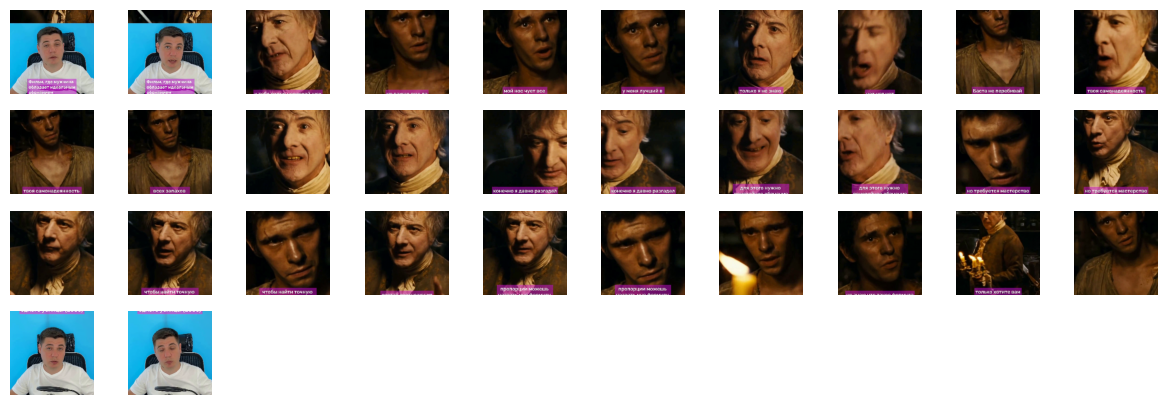

In [6]:
video_path = "datasets/dublicates_video/pair_0/5eb4127e-5694-492b-963c-6688522e9ad2.mp4"
nframes = 32

video_data = VideoReader(video_path, nframes).get_video_data()

num_frames = video_data["video"].shape[1]
num_frames_to_show = 32
frames = []

timestamps = np.linspace(0, num_frames, num_frames_to_show, dtype=int, endpoint=False)

for t in timestamps:
    frame = video_data["video"][:, t, :, :]
    frames.append(unnormalize(frame.permute(1, 2, 0).numpy()))

ncols=10
nrows = int(np.ceil(num_frames_to_show / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5))
axes = axes.flatten()
for ax, frame in zip(axes, frames):
    ax.imshow(frame)
    
[ax.axis('off') for ax in axes]
plt.show()

### Load an example video
We can test the classification of an example video from the kinetics validation set such as this [archery video](https://www.youtube.com/watch?v=3and4vWkW4s).

In [20]:
v1 = VideoReader("datasets/dublicates_video/pair_0/5eb4127e-5694-492b-963c-6688522e9ad2.mp4", 32).get_embeding()
v2 = VideoReader("datasets/dublicates_video/pair_0/3726bb2d-3323-41f8-8eb2-0d7cf095d62b.mp4", 32).get_embeding()

dot(v1, v2)/(norm(v1)*norm(v2))

0.9944805

In [7]:
count = 500
similarities_pairs = {}
for folder in tqdm(glob(f"datasets/dublicates_video/*")[:count]):
    pair_videonames = os.listdir(folder)

    v1 = VideoReader(f"{folder}/{pair_videonames[0]}").get_embeding()
    v2 = VideoReader(f"{folder}/{pair_videonames[1]}").get_embeding()
    similarity = dot(v1, v2)/(norm(v1)*norm(v2))

    similarities_pairs[folder] = similarity
    # nfiles = len(os.listdir(folder))

100%|██████████| 500/500 [30:58<00:00,  3.72s/it]


In [8]:
count = 500
similarities_not_pairs = {}

folders = glob(f"datasets/dublicates_video/*")
for _ in tqdm(range(count)):
    pair_videofolders = np.random.choice(folders, 2, False)
    pair_videonames = [os.listdir(f)[0] for f in pair_videofolders] 

    v1 = VideoReader(f"{pair_videofolders[0]}/{pair_videonames[0]}").get_embeding()
    v2 = VideoReader(f"{pair_videofolders[1]}/{pair_videonames[1]}").get_embeding()
    similarity = dot(v1, v2)/(norm(v1)*norm(v2))

    similarities_not_pairs[pair_videofolders[0] +"_" + pair_videofolders[1]] = similarity

  0%|          | 0/500 [00:00<?, ?it/s]

 32%|███▏      | 162/500 [10:10<26:23,  4.68s/it]

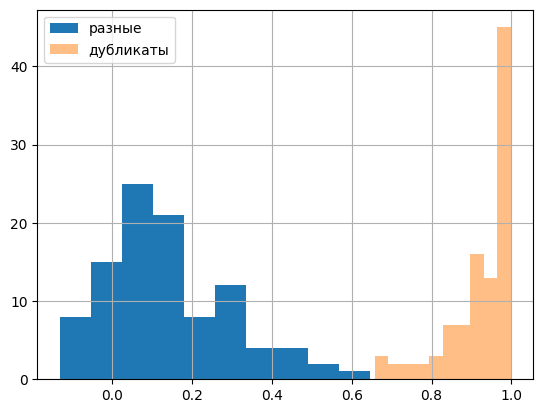

In [16]:
plt.hist(similarities_not_pairs.values(), label="разные")
plt.hist(similarities_pairs.values(), label="дубликаты", alpha=0.5)
plt.grid()
plt.legend()

In [17]:
conf_thresh = 0.6

not_pairs_predicts = (np.array(list(similarities_not_pairs.values())) > conf_thresh).astype(int)
not_pairs_gt = np.zeros_like(not_pairs_predicts)

pairs_predicts = (np.array(list(similarities_pairs.values())) > conf_thresh).astype(int)
pairs_gt = np.ones_like(pairs_predicts)

gt = np.concatenate([not_pairs_gt, pairs_gt])
preds = np.concatenate([not_pairs_predicts, pairs_predicts])

In [18]:
TP = np.sum(preds * gt)
FP = np.sum(preds * (1 - gt))
FN = np.sum((1 - preds) * gt)

# Вычисление Precision
precision = TP / (TP + FP) if (TP + FP) != 0 else 0

# Вычисление Recall (Sensitivity)
recall = TP / (TP + FN) if (TP + FN) != 0 else 0

# Вычисление F1-score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("precision:", round(precision, 4))
print("recall:", round(recall, 4))
print("f1_score:", round(f1_score, 4))

precision: 0.9901
recall: 1.0
f1_score: 0.995
